<a href="https://colab.research.google.com/github/mkosaka1/capstone_project/blob/master/eda_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


# Single file

In [ ]:
import librosa
x, sr = librosa.load('/content/drive/My Drive/audio/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')

In [ ]:
import librosa
x, sr = librosa.load('/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')

In [ ]:
print(x.shape)
print(sr)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

In [ ]:
from IPython.display import Audio

In [ ]:
Audio(data=x, rate=sr)

In [ ]:
single_mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=13)
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
librosa.display.specshow(single_mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

In [ ]:
single_mfcc

# Whole Dataset (1440 files)

In [2]:
# IMPORT NECESSARY LIBRARIES
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
from IPython.display import Audio
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import keras
from keras.optimizers import SGD
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from keras.utils import to_categorical

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

This means the meta data for the audio file is:

Video-only (02)

Speech (01)

Fearful (06)

Normal intensity (01)

Statement "dogs" (02)

1st Repetition (01)

12th Actor (12) - Female (as the actor ID number is even)

In [ ]:
audio = "/content/drive/My Drive/audio/audio_speech_actors_01-24/"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:5]

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05']

In [ ]:
audio = "/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/"

actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:5]

In [ ]:
audio

In [ ]:
# audio/audio/audio_speech_actors_01-24/Actor_14
# 03-01-02-01-02-01-14.wav

emotion = []
gender = []
file_path = []
for i in actor_folders:
    filename = os.listdir(audio + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio + i + '/' + f)

In [ ]:
os.listdir(audio + i)

['03-01-06-01-02-02-24.wav',
 '03-01-04-01-02-02-24.wav',
 '03-01-03-02-02-01-24.wav',
 '03-01-06-01-02-01-24.wav',
 '03-01-04-01-01-02-24.wav',
 '03-01-05-02-02-02-24.wav',
 '03-01-04-02-02-01-24.wav',
 '03-01-01-01-01-02-24.wav',
 '03-01-05-02-01-01-24.wav',
 '03-01-06-02-02-01-24.wav',
 '03-01-04-01-01-01-24.wav',
 '03-01-01-01-01-01-24.wav',
 '03-01-05-01-02-02-24.wav',
 '03-01-02-01-02-02-24.wav',
 '03-01-02-02-01-02-24.wav',
 '03-01-07-01-02-01-24.wav',
 '03-01-06-01-01-01-24.wav',
 '03-01-03-01-01-02-24.wav',
 '03-01-03-01-01-01-24.wav',
 '03-01-04-01-02-01-24.wav',
 '03-01-07-01-01-01-24.wav',
 '03-01-06-01-01-02-24.wav',
 '03-01-02-02-01-01-24.wav',
 '03-01-02-01-02-01-24.wav',
 '03-01-05-02-02-01-24.wav',
 '03-01-04-02-01-01-24.wav',
 '03-01-05-01-01-02-24.wav',
 '03-01-04-02-01-02-24.wav',
 '03-01-03-02-02-02-24.wav',
 '03-01-04-02-02-02-24.wav',
 '03-01-03-02-01-02-24.wav',
 '03-01-05-01-01-01-24.wav',
 '03-01-06-02-01-02-24.wav',
 '03-01-02-02-02-02-24.wav',
 '03-01-01-01-

In [ ]:
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df
audio_df = pd.concat([pd.DataFrame(gender),audio_df],axis=1)
audio_df.columns = ['gender','emotion']
# audio_df['labels'] =audio_df.gender + '_' + audio_df.emotion
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
# audio_df = audio_df.drop(['gender', 'emotion'], axis=1)
# audio_df.labels.value_counts()
audio_df

# GENDER + EMOTION
# audio_df = pd.DataFrame(emotion)
# audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
# audio_df = pd.concat([pd.DataFrame(gender),audio_df],axis=1)
# audio_df.columns = ['gender','emotion']
# audio_df['labels'] =audio_df.gender + '_' + audio_df.emotion
# audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
# audio_df = audio_df.drop(['gender', 'emotion'], axis=1)
# audio_df.labels.value_counts()

,gender,emotion,path
0,male,fear,/content/drive/My Drive/audio/audio_speech_act...
1,male,neutral,/content/drive/My Drive/audio/audio_speech_act...
2,male,happy,/content/drive/My Drive/audio/audio_speech_act...
3,male,happy,/content/drive/My Drive/audio/audio_speech_act...
4,male,calm,/content/drive/My Drive/audio/audio_speech_act...
...,...,...,...
1435,female,surprise,/content/drive/My Drive/audio/audio_speech_act...
1436,female,disgust,/content/drive/My Drive/audio/audio_speech_act...
1437,female,surprise,/content/drive/My Drive/audio/audio_speech_act...
1438,female,surprise,/content/drive/My Drive/audio/audio_speech_act...


In [ ]:
audio_df.to_csv('audio.csv')

In [ ]:

os.listdir(audio)

In [ ]:
fname = audio + 'Actor_02/03-01-01-01-01-01-02.wav'  #female neutral
data_neutral, sr_neutral = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(data_neutral, sr=sr_neutral)
ipd.Audio(fname)

In [ ]:
fname = audio + 'Actor_02/03-01-02-01-01-01-02.wav'  #female calm
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(data, sr=sampling_rate)
ipd.Audio(fname)


# MFCC
### The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. MFCC is a good "representation" of the vocal tract that produces the sound. Think of it like an x-ray of your mouth

In [ ]:
fa_mfcc = librosa.feature.mfcc(y=data_neutral, sr=sr_neutral, n_mfcc=13)
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
librosa.display.specshow(fa_mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

In [ ]:
# MFCC
#The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features 
#(usually about 10–20) which concisely describe the overall shape of a spectral envelope.
# good "representation" of the vocal tract that produces the sound. Think of it like an 
# x-ray of your mouth
mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13)

plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar();

In [ ]:
mfcc.shape

216
216
216
216


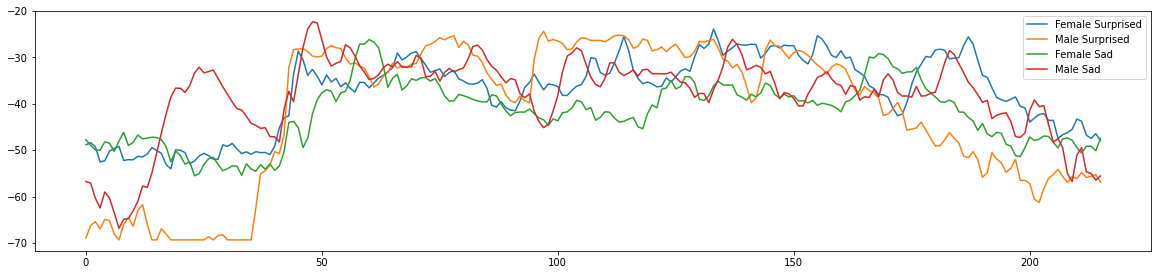

In [ ]:
# Male surprised
pathh = audio + 'Actor_09/03-01-08-02-02-02-09.wav'
X, sample_rate = librosa.load(pathh, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Female surprised
path= audio + 'Actor_08/03-01-08-02-02-02-08.wav'
X, sample_rate = librosa.load(path,duration=2.5,sr=22050*2,offset=0.5)
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Male sad
pathh = audio + 'Actor_09/03-01-04-02-02-02-09.wav'
X, sample_rate = librosa.load(pathh, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
male1 = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male1 = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male1))

# Female sad
path= audio + 'Actor_08/03-01-04-02-02-02-08.wav'
X, sample_rate = librosa.load(path,duration=2.5,sr=22050*2,offset=0.5)
female1 = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female1 = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female1))

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='Female Surprised')
plt.plot(male, label='Male Surprised')
plt.plot(female1, label='Female Sad')
plt.plot(male1, label='Male Sad')
plt.legend()



In [ ]:
# Spectrogram - how the audio spectrum varies as a function of time
spectrogram = librosa.feature.melspectrogram(y=X, sr=sampling_rate)
db_spec = librosa.power_to_db(spectrogram, ref=np.max,)
librosa.display.specshow(db_spec,y_axis='mel', x_axis='time', sr=sampling_rate)
plt.colorbar();

## Feature Extraction

In [ ]:
df = pd.DataFrame(columns=['mfcc_feature'])

counter=0

for index,path in enumerate(audio_df.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        
    #Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
    #temporal averaging
    mfcc=np.mean(mfcc,axis=0)

    
    # #get the mel-scaled spectrogram ()
    # spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)  
    # #temporally average spectrogram
    # spectrogram = np.mean(spectrogram, axis = 0)
    
    # #compute chroma energy (pertains to 12 different pitch classes)
    # chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
    # #temporally average chroma
    # chroma = np.mean(chroma, axis = 0)
    
    # #compute spectral contrast
    # contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
    # contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
    # which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
    # zcr = librosa.feature.zero_crossing_rate(y=X)
    # zcr = np.mean(zcr, axis= 0)
    
    df.loc[counter] = [mfcc]
    counter=counter+1   

print(len(df))
df.head()

1440


,mfcc_feature
0,"[-63.52352959684379, -63.52352959684379, -63.5..."
1,"[-65.8009712673087, -65.8009712673087, -65.800..."
2,"[-58.73100684143704, -58.74653122015798, -58.0..."
3,"[-65.24334603230012, -65.24334603230012, -65.2..."
4,"[-67.55739512198222, -67.55739512198222, -67.5..."


In [ ]:
print (mfcc.mean(axis=1))
print (mfcc.var(axis=1))

IndexError: ignored

In [ ]:
df.columns

Index(['mfcc_feature', 'spec_feat', 'chroma_feat', 'contrast_feat'], dtype='object')

In [ ]:
df = pd.DataFrame(columns=['mfcc_feature'])

# feature extraction over the entire dataset
counter=0
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=44100,offset=0.5)
    sample_rate = np.array(sample_rate)
    
    mfcc = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   


print(len(df))
df.head()


NameError: ignored

In [ ]:
df_chroma = pd.DataFrame(columns=['chroma_feat'])

# feature extraction over the entire dataset
counter=0
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=44100,offset=0.5)
    sample_rate = np.array(sample_rate)
    
    chroma=np.mean(librosa.feature.chroma_stft(X, sr=sample_rate).T,axis=0)
    df_chroma.loc[counter] = [chroma]
    counter=counter+1   


print(len(df_chroma))
df_chroma.head()

In [ ]:
# rmse = librosa.feature.rmse(y=y)
# spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr) : DO NOT USE - INDICATES WHERE CENTER OF MASS IS, IS THE SAME FOR HAPPY AND SURPRISED
# spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
# rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
# zcr = librosa.feature.zero_crossing_rate(y)

## CNN

In [ ]:
# Extract the mean bands to its own feature columns
df_combined = pd.concat([audio_df,pd.DataFrame(df['mfcc_feature'].values.tolist()),
                        #  pd.DataFrame(df['chroma_feat'].values.tolist()),
                        #  pd.DataFrame(df['spec_feat'].values.tolist())
                         ],axis=1)
df_combined = df_combined.fillna(0)

In [ ]:
df_combined.drop(columns='gender',inplace=True)

In [ ]:
df_combined.head()

,emotion,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,fear,/content/drive/My Drive/audio/audio_speech_act...,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.377373,-61.595853,-63.160227,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.486761,-63.453534,-60.923158,-58.164801,-58.033787,-57.377220,-58.619264,-57.489921,-57.051144,-58.815463,-59.090078,-58.199690,-57.456970,-53.362825,-48.075103,...,9.470058e-06,2.578390e-05,2.461057e-05,1.202463e-05,5.154764e-06,2.293928e-06,8.568837e-07,1.537127e-06,2.078454e-06,2.184434e-06,3.041122e-06,1.803422e-06,1.143403e-06,7.627434e-07,3.888000e-07,1.779640e-07,1.923068e-07,3.168509e-07,2.245657e-07,2.101146e-07,1.500544e-07,1.671772e-07,1.471501e-07,1.313681e-07,8.375042e-08,3.572479e-08,2.370430e-08,3.129491e-08,2.816052e-08,2.174507e-08,2.531549e-08,1.924894e-08,1.741787e-08,1.225668e-08,7.529888e-09,5.454092e-09,6.819510e-09,1.796941e-08,1.751192e-08,7.574554e-09
1,neutral,/content/drive/My Drive/audio/audio_speech_act...,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.793168,-65.800971,-65.800971,-65.800971,-63.896145,-60.063347,-61.391446,-59.506572,-61.304348,-60.479436,-59.622011,-59.312969,-56.807714,-57.467487,-54.780278,-54.338120,-56.671499,-56.021689,-55.159339,-55.876813,-56.127683,-56.435845,...,3.132524e-09,2.293366e-09,1.289942e-09,3.135538e-09,4.808926e-09,9.926860e-09,4.514360e-09,3.569078e-10,3.039941e-10,4.092756e-10,2.502424e-10,8.785423e-11,4.097390e-10,3.496092e-10,8.525146e-11,9.268422e-11,2.479107e-11,1.047995e-10,6.573235e-10,1.409621e-09,3.839809e-10,9.462552e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,happy,/content/drive/My Drive/audio/audio_speech_act...,-58.731007,-58.746531,-58.048578,-57.370804,-58.199914,-59.706633,-59.876183,-59.998060,-59.936650,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.249521,-60.257292,-57.940615,-57.685275,-58.743272,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-59.475713,-59.103223,-56.911964,...,2.422831e-07,1.714550e-07,1.098402e-07,1.919263e-07,2.688476e-07,1.465773e-07,1.096860e-07,9.550388e-08,1.298970e-07,1.184836e-07,1.274261e-07,2.088348e-07,1.981786e-07,1.049217e-07,5.793580e-08,7.813114e-08,8.910524e-08,3.787632e-08,4.967923e-08,5.793108e-08,2.227009e-08,2.370553e-08,2.333633e-08,1.691262e-08,1.855947e-08,2.228112e-08,1.963106e-08,1.471574e-08,2.673383e-08,2.712630e-08,1.231842e-08,7.812410e-09,7.712507e-10,7.638044e-10,1.757530e-09,2.919100e-09,8.747867e-10,4.573883e-10,5.310010e-10,7.820663e-11
3,happy,/content/drive/My Drive/audio/audio_speech_act...,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.117574,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-64.744637,-59.645945,-62.325064,-65.276450,-65.243346,-65.243577,-63.977965,-62.763801,-64.460970,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.235624,-62.331518,-61.644450,-63.583881,-64.115173,-61.981372,...,1.324463e-07,1.342138e-07,2.391723e-07,1.658444e-07,1.556888e-07,1.030683e-07,1.267966e-07,1.693123e-07,1.926444e-07,1.948504e-07,5.296063e-08,3.158196e-08,5.809344e-08,1.287589e-07,1.516797e-07,2.053868e-07,4.422756e-07,3.753533e-07,2.2

In [ ]:
# Extract the mean bands to its own feature columns
df = pd.concat([audio_df,pd.DataFrame(df['mfcc_feature'].values.tolist())],axis=1)
df=df.fillna(0)

In [ ]:
df_combined.head()

,emotion,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,fear,/content/drive/My Drive/audio/audio_speech_act...,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.377373,-61.595853,-63.160227,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.486761,-63.453534,-60.923158,-58.164801,-58.033787,-57.377220,-58.619264,-57.489921,-57.051144,-58.815463,-59.090078,-58.199690,-57.456970,-53.362825,-48.075103,...,9.470058e-06,2.578390e-05,2.461057e-05,1.202463e-05,5.154764e-06,2.293928e-06,8.568837e-07,1.537127e-06,2.078454e-06,2.184434e-06,3.041122e-06,1.803422e-06,1.143403e-06,7.627434e-07,3.888000e-07,1.779640e-07,1.923068e-07,3.168509e-07,2.245657e-07,2.101146e-07,1.500544e-07,1.671772e-07,1.471501e-07,1.313681e-07,8.375042e-08,3.572479e-08,2.370430e-08,3.129491e-08,2.816052e-08,2.174507e-08,2.531549e-08,1.924894e-08,1.741787e-08,1.225668e-08,7.529888e-09,5.454092e-09,6.819510e-09,1.796941e-08,1.751192e-08,7.574554e-09
1,neutral,/content/drive/My Drive/audio/audio_speech_act...,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.793168,-65.800971,-65.800971,-65.800971,-63.896145,-60.063347,-61.391446,-59.506572,-61.304348,-60.479436,-59.622011,-59.312969,-56.807714,-57.467487,-54.780278,-54.338120,-56.671499,-56.021689,-55.159339,-55.876813,-56.127683,-56.435845,...,3.132524e-09,2.293366e-09,1.289942e-09,3.135538e-09,4.808926e-09,9.926860e-09,4.514360e-09,3.569078e-10,3.039941e-10,4.092756e-10,2.502424e-10,8.785423e-11,4.097390e-10,3.496092e-10,8.525146e-11,9.268422e-11,2.479107e-11,1.047995e-10,6.573235e-10,1.409621e-09,3.839809e-10,9.462552e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,happy,/content/drive/My Drive/audio/audio_speech_act...,-58.731007,-58.746531,-58.048578,-57.370804,-58.199914,-59.706633,-59.876183,-59.998060,-59.936650,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.249521,-60.257292,-57.940615,-57.685275,-58.743272,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-59.475713,-59.103223,-56.911964,...,2.422831e-07,1.714550e-07,1.098402e-07,1.919263e-07,2.688476e-07,1.465773e-07,1.096860e-07,9.550388e-08,1.298970e-07,1.184836e-07,1.274261e-07,2.088348e-07,1.981786e-07,1.049217e-07,5.793580e-08,7.813114e-08,8.910524e-08,3.787632e-08,4.967923e-08,5.793108e-08,2.227009e-08,2.370553e-08,2.333633e-08,1.691262e-08,1.855947e-08,2.228112e-08,1.963106e-08,1.471574e-08,2.673383e-08,2.712630e-08,1.231842e-08,7.812410e-09,7.712507e-10,7.638044e-10,1.757530e-09,2.919100e-09,8.747867e-10,4.573883e-10,5.310010e-10,7.820663e-11
3,happy,/content/drive/My Drive/audio/audio_speech_act...,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.117574,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-64.744637,-59.645945,-62.325064,-65.276450,-65.243346,-65.243577,-63.977965,-62.763801,-64.460970,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.235624,-62.331518,-61.644450,-63.583881,-64.115173,-61.981372,...,1.324463e-07,1.342138e-07,2.391723e-07,1.658444e-07,1.556888e-07,1.030683e-07,1.267966e-07,1.693123e-07,1.926444e-07,1.948504e-07,5.296063e-08,3.158196e-08,5.809344e-08,1.287589e-07,1.516797e-07,2.053868e-07,4.422756e-07,3.753533e-07,2.2

In [ ]:
from sklearn.model_selection import train_test_split

# TRAIN TEST SPLIT
X_model, X_test, y_model, y_test = train_test_split(df_combined.drop(['path','emotion'],axis=1)
                                                    , df_combined.emotion
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                    , stratify = df_combined.emotion
                                                   )



In [ ]:
# TRAIN TEST SPLIT
X_train, X_validation, y_train, y_validation = train_test_split(X_model
                                                    , y_model
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                    , stratify = y_model
                                                   )


In [ ]:
df_combined[df_combined.index.duplicated()]



,emotion,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258


In [ ]:
#Data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_validation = (X_validation - mean)/std

# Check the dataset now 
X_train[150:160]

TypeError: ignored

In [ ]:
len(X_train)

810

In [ ]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

In [ ]:
y_test

array(['calm', 'happy', 'neutral', 'happy', 'calm', 'happy', 'calm',
       'neutral', 'calm', 'calm', 'happy', 'happy', 'happy', 'calm',
       'calm', 'calm', 'neutral', 'sad', 'happy', 'neutral', 'happy',
       'disgust', 'sad', 'surprise', 'angry', 'angry', 'fear', 'disgust',
       'fear', 'disgust', 'angry', 'angry', 'disgust', 'fear', 'surprise',
       'surprise', 'disgust', 'disgust', 'surprise', 'sad', 'sad',
       'surprise', 'fear', 'sad', 'angry', 'sad', 'surprise', 'fear',
       'disgust', 'fear', 'surprise', 'angry', 'fear', 'fear', 'disgust',
       'surprise', 'angry', 'sad', 'sad', 'angry', 'neutral', 'neutral',
       'calm', 'calm', 'calm', 'happy', 'neutral', 'calm', 'calm', 'calm',
       'calm', 'calm', 'neutral', 'happy', 'disgust', 'fear', 'surprise',
       'fear', 'disgust', 'sad', 'sad', 'happy', 'angry', 'disgust',
       'happy', 'sad', 'fear', 'happy', 'angry', 'angry', 'angry', 'fear',
       'surprise', 'happy', 'sad', 'fear', 'surprise', 'surprise',

In [ ]:
len(y_train)

810

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils, to_categorical

# # one hot encode the target 
# CNN requires input and output are numbers
lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_train = to_categorical(y_train)
y_test = lb.fit_transform(y_test)
y_test = to_categorical(y_test)
y_validation = lb.fit_transform(y_validation)
y_validation = to_categorical(y_validation)
print(y_train[0:10])


# lb = LabelEncoder()
# y_train = to_categorical(lb.fit_transform(y_train))
# y_test = to_categorical(lb.fit_transform(y_test))
# print(y_train[0:10])

# # # one hot encode the target 
# lb = LabelEncoder()
# y_train = np_utils.to_categorical(lb.fit_transform(y_train))
# y_test = np_utils.to_categorical(lb.fit_transform(y_test))
# print(y_train[0:10])



[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]


In [ ]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [ ]:
#time series data requires kernel sliding in only one dimension and have spatial properties
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_validation = X_validation[:,:,np.newaxis]

# X_train = np.expand_dims(X_train, axis=2)
# X_test = np.expand_dims(X_test, axis=2)
# X_train.shape

In [ ]:
y_train.shape

In [ ]:
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM

# model = Sequential()
# model.add(Conv1D(32, kernel_size=(3), activation='relu', input_shape=(X_train.shape[1],1)))
# model.add(Conv1D(64, kernel_size=(3), activation='relu'))
# model.add(MaxPooling1D(pool_size=(2)))
# model.add(Conv1D(128, kernel_size=(4), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=(2)))
# model.add(Dropout(0.25))
# model.add(Conv1D(64, kernel_size=(3), activation='relu'))
# model.add(MaxPooling1D(pool_size=(2)))
# model.add(Dropout(0.25))
# model.add(Conv1D(128, kernel_size=(3), activation='relu'))
# model.add(MaxPooling1D(pool_size=(2)))
# model.add(Dropout(0.25))
# model.add(Conv1D(128, kernel_size=(3), activation='relu'))
# model.add(MaxPooling1D(pool_size=(2)))
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(8, activation='softmax'))
# model.summary()
# opt = keras.optimizers.Adam(lr=0.0001)



model = Sequential()
model.add(Conv1D(64, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(256, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_346"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1733 (Conv1D)         (None, 777, 64)           576       
_________________________________________________________________
activation_31 (Activation)   (None, 777, 64)           0         
_________________________________________________________________
conv1d_1734 (Conv1D)         (None, 777, 64)           32832     
_________________________________________________________________
batch_normalization_10 (Batc (None, 777, 64)           256       
_________________________________________________________________
activation_32 (Activation)   (None, 777, 64)           0         
_________________________________________________________________
dropout_1373 (Dropout)       (None, 777, 64)           0         
_________________________________________________________________
max_pooling1d_1373 (MaxPooli (None, 97, 64)         

In [ ]:
batch_size=1
epochs=50

In [ ]:
val_loss_thresh = 4.00

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_loss') > val_loss_thresh):   
          print("\nWe have reached %2.2f%% val_loss, so we will stopping training.")   
        self.model.stop_training = True
callbacks = myCallback()


In [ ]:
# categorical crossentropy since output variable has more than 2 label classes

# model.compile(loss='sparse_categorical_crossentropy',
#                       optimizer='rmsprop',
#                       metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_validation, y_validation),callbacks=[callbacks])

Epoch 1/50
810/810 [==============================] - 27s 34ms/step - loss: 1.3590 - accuracy: 0.5049 - val_loss: 1.7924 - val_accuracy: 0.2926


In [ ]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

12/12 [==============================] - 1s 49ms/step - loss: 4.6382 - accuracy: 0.3528
Loss of the model is -  4.638173580169678
12/12 [==============================] - 1s 51ms/step - loss: 4.6382 - accuracy: 0.3528
Accuracy of the model is -  35.277777910232544 %


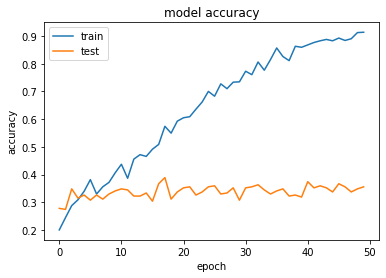

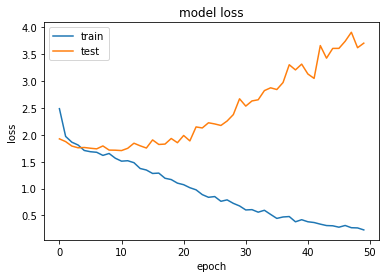

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#100 epoch
# accuracy: .8620, 38.88
# 0.7935, loss:1.88, 41.94

In [ ]:
# 50 epoch
# val_accuracy = .3972 mfcc
      # .3722 mfcc
# val_accuracy = 0.2139 chroma
# val_accuracy = 0.0639 mfcc + chroma
# 50 epoch - changed random_state
# val_accuracy

In [ ]:
# def extract_feature(file_name, mfcc, chroma, mel):
#     with soundfile.SoundFile(file_name) as sound_file:
#         X = sound_file.read(dtype="float32")
#         sample_rate=sound_file.samplerate
#         if chroma:
#             stft=np.abs(librosa.stft(X))
#         result=np.array([])
#         if mfcc:
#             mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
#             result=np.hstack((result, mfccs))
#         if chroma:
#             chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
#             result=np.hstack((result, chroma))
#         if mel:
#             mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
#             result=np.hstack((result, mel))

DATA AUGMENTATION

In [ ]:
pre_aug= pd.read_csv('audio.csv',usecols=['emotion','path'])
pre_aug.head()

,emotion,path
0,fear,/content/drive/My Drive/audio/audio_speech_act...
1,neutral,/content/drive/My Drive/audio/audio_speech_act...
2,happy,/content/drive/My Drive/audio/audio_speech_act...
3,happy,/content/drive/My Drive/audio/audio_speech_act...
4,calm,/content/drive/My Drive/audio/audio_speech_act...


In [ ]:
from tqdm import tqdm


In [ ]:
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

In [ ]:
df1 = pd.DataFrame(columns=['feature'])
df_noise = pd.DataFrame(columns=['feature'])
df_speedpitch = pd.DataFrame(columns=['feature'])
cnt = 0

# loop feature extraction over the entire dataset
for i in tqdm(pre_aug.path):
    
    # first load the audio 
    X, sample_rate = librosa.load(i
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )

    # take mfcc and mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=np.array(sample_rate), 
                                        n_mfcc=13),
                    axis=0)
    
    df1.loc[cnt] = [mfccs]   

    # random shifting (omit for now)
    # Stretch
    # pitch (omit for now)
    # dyn change
    
    # noise 
    aug = noise(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_noise.loc[cnt] = [aug]

    # speed pitch
    aug = speedNpitch(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_speedpitch.loc[cnt] = [aug]   

    cnt += 1

df1.head()

100%|██████████| 1440/1440 [10:56<00:00,  2.19it/s]


,feature
0,"[-63.52352959684379, -63.52352959684379, -63.5..."
1,"[-65.8009712673087, -65.8009712673087, -65.800..."
2,"[-58.73100684143704, -58.74653122015798, -58.0..."
3,"[-65.24334603230012, -65.24334603230012, -65.2..."
4,"[-67.55739512198222, -67.55739512198222, -67.5..."


In [ ]:
df.head()

,emotion,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,fear,/content/drive/My Drive/audio/audio_speech_act...,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.377373,-61.595853,-63.160227,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.486761,-63.453534,-60.923158,-58.164801,-58.033787,-57.377220,-58.619264,-57.489921,-57.051144,-58.815463,-59.090078,-58.199690,-57.456970,-53.362825,-48.075103,...,-29.173452,-30.587588,-29.460077,-29.089244,-28.431386,-27.486497,-25.458800,-23.080926,-21.972054,-21.471052,-23.320959,-26.888781,-28.113588,-27.575900,-28.785640,-32.255878,-35.242089,-35.369591,-36.281778,-39.144354,-39.930927,-39.638008,-40.616663,-40.774148,-40.808047,-43.076379,-40.145070,-39.692720,-39.173858,-41.141976,-39.336517,-39.847823,-40.466040,-40.448086,-42.883065,-43.367558,-46.280296,-48.273818,-49.745182,-50.472916
1,neutral,/content/drive/My Drive/audio/audio_speech_act...,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.793168,-65.800971,-65.800971,-65.800971,-63.896145,-60.063347,-61.391446,-59.506572,-61.304348,-60.479436,-59.622011,-59.312969,-56.807714,-57.467487,-54.780278,-54.338120,-56.671499,-56.021689,-55.159339,-55.876813,-56.127683,-56.435845,...,-59.615328,-56.169903,-57.875562,-61.149496,-62.058126,-58.724914,-56.277627,-58.083108,-60.733636,-62.754215,-63.549244,-64.526266,-65.800971,-65.771172,-62.390423,-60.171205,-61.831569,-64.845866,-64.133097,-63.383669,-61.310815,-60.995465,-62.350353,-62.845241,-60.302466,-58.946521,-59.711816,-56.837098,-56.425769,-56.877954,-58.299903,-62.295248,-64.930130,-65.332128,-64.116934,-64.319911,-64.971422,-63.155779,-64.178668,-63.061902
2,happy,/content/drive/My Drive/audio/audio_speech_act...,-58.731007,-58.746531,-58.048578,-57.370804,-58.199914,-59.706633,-59.876183,-59.998060,-59.936650,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.249521,-60.257292,-57.940615,-57.685275,-58.743272,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-59.475713,-59.103223,-56.911964,...,-31.040709,-33.111956,-33.920179,-32.848093,-33.748947,-28.912804,-27.902163,-28.814746,-31.916543,-35.159089,-34.600029,-36.534142,-39.675174,-39.090560,-41.211511,-41.615766,-42.982944,-44.552441,-46.767227,-48.901993,-48.182536,-49.397835,-52.824407,-56.451427,-57.427653,-57.040867,-57.964446,-56.713111,-58.412082,-55.622810,-54.060476,-50.477974,-50.955292,-55.110642,-53.636647,-57.134217,-58.249914,-56.417940,-54.576753,-51.933967
3,happy,/content/drive/My Drive/audio/audio_speech_act...,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.117574,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-64.744637,-59.645945,-62.325064,-65.276450,-65.243346,-65.243577,-63.977965,-62.763801,-64.460970,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.235624,-62.331518,-61.644450,-63.583881,-64.115173,-61.981372,...,-28.062840,-29.369646,-29.820460,-30.109136,-31.332308,-31.719834,-33.486261,-33.912020,-35.084887,-35.643135,-34.758229,-37.127739,-37.751217,-38.426617,-37.518583,-39.169836,-41.366591,-40.636799,-41.597277,-43.202094,-46.921002,-46.835675,-47.064398,-49.522141,-54.357303,-56.299573,-56.148744,-59.039572,-59.224522,-59.682462,-59.875894,-61.924273,-56.156915,-55.677974,-61.117810,-58.568728,-57.136813,-58.619914,-60.068312,-57.350593
4,calm,/content/drive/My Drive/audio/

In [ ]:
# combine 
df = pd.concat([pre_aug,pd.DataFrame(df.feature.values.tolist())],axis=1)
df_noise = pd.concat([pre_aug,pd.DataFrame(df_noise['feature'].values.tolist())],axis=1)
df_speedpitch = pd.concat([pre_aug,pd.DataFrame(df_speedpitch['feature'].values.tolist())],axis=1)
print(df.shape,df_noise.shape,df_speedpitch.shape)

AttributeError: ignored